In [1]:
"""
Configs:
    # Env
    env_id="NNWorld01-v01", 
     - once in the goal state, each action ends the episode and returns a reward of 5
     - no clear episodes, continuously train the agent with num_train_steps, 
       if the agent reaches terminal, just reset environment and keep training 
     - try to immitate the bandit experiments
    # Params
    eps_sched_fn=poly(0.5), lr_sched_fn=poly(0.8)
    # Algos
    haver2, action_sigma=adaptive(1), haver_delta=0.01, haver_const=varied
Status:
"""

from collections import defaultdict
import random
import numpy as np
np.set_printoptions(precision=2, suppress=True)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
sns.set_palette("tab20")
colors = sns.color_palette("bright")

import time
from tqdm import tqdm 
import multiprocessing

# import gymnasium as gym
import gym
import gym_examples
from gym.wrappers import FlattenObservation

from algos import *
from bandit_problem import *
from utils import *

In [2]:

random.seed(123)
np.random.seed(123)
tdqm_disable = True

# params
num_trials = 1
num_steps_train = 5000
num_episodes_eval = 100

lr_sched_type = "linear"
lr_sched_fn = create_lr_sched_fn(lr_sched_type, lr=0.7)

max_eps = 1.0
min_eps = 1.0
decay_rate = 0.0001
eps_sched_type = "poly"
eps_sched_fn = create_eps_sched_fn(eps_sched_type, min_eps, max_eps, decay_rate)

# create gym env
env_id = "gym_examples/NNWorldEnv01-v1"
env_scheme = "two_island"
gamma = 0.95

num_depths = 4
num_widths = 16
num_actions = num_widths
terminal_reward = -10.0

reward_dist = "normal"
problem_instance = "multi_gap_nonlinear"
action_max_mu = 0.0
action_sigma = 10.0
action_sigmas = action_sigma*np.ones(num_actions)
gap_splits = [0.5]
gap_deltas = [5.0]
bandit_problem = BanditProblem(
    problem_instance, reward_dist, num_actions, action_max_mu, 
    action_sigmas=action_sigmas, gap_splits=gap_splits, gap_deltas=gap_deltas)
print(f"action_mus = {bandit_problem.action_mus}")
print(f"action_sigmas = {bandit_problem.action_sigmas}")

action_max_mu = bandit_problem.action_mus[0]
optimal_num_steps = num_depths
optimal_vstar = terminal_reward*gamma**(optimal_num_steps-1) \
    + action_max_mu*np.sum([gamma**k for k in range(optimal_num_steps-1)])
optimal_reward_per_step = (terminal_reward + action_max_mu*(optimal_num_steps-1))/optimal_num_steps  
print(f"optimal_num_steps = {optimal_num_steps}")
print(f"optimal_reward_per_step = {optimal_reward_per_step}")
print(f"optimal_vstar = {optimal_vstar}")

env = gym.make(env_id, num_depths=num_depths, num_widths=num_widths, 
               bandit_problem=bandit_problem, terminal_reward=terminal_reward)
env_wrapped = FlattenObservation(env)
cur_state, info = env_wrapped.reset()

manager = multiprocessing.Manager()
episode_start_sigmahats_list = manager.list()
episode_rewards_list = manager.list()
episode_vstar_est_list = manager.list()
Q_table_list = manager.list()
Q_nvisits_list = manager.list()    

def run_trial(i_trial, args):

    random.seed(10000+i_trial)
    np.random.seed(10000+i_trial)

    # env = gym.make(env_id, size=gridworld_size)
    # env_wrapped = FlattenObservation(env)
    # env_wrapped.reset(seed=10000+i_trial)

    # lr_sched_fn = create_lr_sched_fn(lr_sched_type)
    # eps_sched_fn = create_eps_sched_fn(eps_sched_type, min_eps, max_eps, decay_rate)
    q_algo = create_q_algo(args["est_name"])

    Q_table, Q_nvisits, stats = q_algo(
        env_wrapped, num_actions, num_steps_train,
        gamma, lr_sched_fn, eps_sched_fn, tdqm_disable, args)

    episode_start_sigmahats, episode_rewards, episode_vstar_est= zip(*stats)
    episode_start_sigmahats_list.append(episode_start_sigmahats)
    episode_rewards_list.append(episode_rewards)
    episode_vstar_est_list.append(episode_vstar_est)
    Q_table_list.append(Q_table)
    Q_nvisits_list.append(Q_nvisits)

args = dict()
args["action_sigma"] = action_sigma
args["haver_alpha"] = 2.0
args["haver_delta"] = 0.05
args["haver_const"] = 1.0
args["weightedms_num_data"] = 1000
args["num_depths"] = num_depths
args["env_scheme"] = env_scheme

pool = multiprocessing.Pool()

episode_start_sigmahats_dict = defaultdict()
episode_rewards_dict = defaultdict()
episode_vstar_est_dict = defaultdict()
episode_vstar_est_bias_dict = defaultdict()
episode_vstar_est_var_dict = defaultdict()
episode_vstar_est_mse_dict = defaultdict()
Q_table_dict = defaultdict()
Q_nvisits_dict = defaultdict()

haver_const_ary = [1.0]
haver_name_ary = [f"haver_{x}" for x in haver_const_ary]
haver3_name_ary = [f"haver3_{x}" for x in haver_const_ary]

est_name_ary = ["max", "weightedms"]
# est_name_ary = haver_name_ary + est_name_ary 
# est_name_ary = est_name_ary + haver_name_ary
# est_name_ary = est_name_ary + haver2_name_ary
est_name_ary = est_name_ary + haver3_name_ary
# est_name_ary = est_name_ary + haver4_name_ary
est_name_ary = ["haver3_1.0"]
for est_name in est_name_ary:
    start_time = time.time()
    print(f"\n-> est_name = {est_name}")
    if "haver" in est_name:
        elems = est_name.split("_")
        args["est_name"] = elems[0]
        args["haver_const"] = float(elems[-1])
        print(f"haver_const = {args['haver_const']}")
    else:
        args["est_name"] = est_name
    
    pool.starmap(run_trial, [(i, args) for i in range(num_trials)])

    episode_start_sigmahats_ary = np.hstack([episode_start_sigmahats_list])
    episode_rewards_ary = np.hstack([episode_rewards_list])
    episode_vstar_est_ary = np.hstack([episode_vstar_est_list])

    episode_start_sigmahats_dict[est_name] = np.mean(episode_start_sigmahats_ary, 0)
    episode_rewards_dict[est_name] = np.mean(episode_rewards_ary, 0)
    episode_vstar_est_dict[est_name] = np.mean(episode_vstar_est_ary, 0)
    print(f"last_episode_start_sigmahat = {episode_start_sigmahats_dict[est_name][-1]:.4f}")
    print(f"last_episode_reward_per_step = {episode_rewards_dict[est_name][-1]:.4f}")
    print(f"last_episode_estim_start_muhat = {episode_vstar_est_dict[est_name][-1]:.4f}")
    
    episode_vstar_est_bias_dict[est_name] = np.mean(episode_vstar_est_ary - optimal_vstar, 0)
    episode_vstar_est_var_dict[est_name] = np.var(episode_vstar_est_ary - optimal_vstar, 0, ddof=1)
    episode_vstar_est_mse_dict[est_name] = \
        episode_vstar_est_bias_dict[est_name]**2 \
        + episode_vstar_est_var_dict[est_name]
    
    # Q_table_dict[est_name] = np.mean(np.stack(Q_table_list), 0)
    # Q_nvisits_dict[est_name] = np.mean(np.stack(Q_nvisits_list), 0)
    # print(np.stack(Q_table_list).shape)
    Q_table_dict[est_name] = np.stack(Q_table_list)[0,:,:,:]
    Q_nvisits_dict[est_name] = np.stack(Q_nvisits_list)[0,:,:,:]
    # print(Q_table_list[0][0,0,:])
    # print(Q_table_list[1][0,0,:])
    # print(Q_table_ary)
    # stop
                           
    episode_start_sigmahats_list[:] = []
    episode_rewards_list[:] = []
    episode_vstar_est_list[:] = []
    Q_table_list[:] = []
    Q_nvisits_list[:] = []
    
    end_time = time.time()
    print(f"it takes {end_time-start_time:0.4f}")

action_mus = [ 0.  0.  0.  0.  0.  0.  0.  0. -5. -5. -5. -5. -5. -5. -5. -5.]
action_sigmas = [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
optimal_num_steps = 4
optimal_reward_per_step = -2.5
optimal_vstar = -8.573749999999999

-> est_name = haver3_1.0
haver_const = 1.0

-> i_step = 4000
cur_state = [0 0]
action = 4
reward = 10.62
new_state = [1 4]
[ 37. 342.   6. 147. 268.  48.  26.  92.   4.   4.   4.   4.   2.  10.
   4.   3.]
[ 37. 342.   6. 147. 268.  48.  26.  92.   4.   4.   4.   4.   2.  10.
   4.   3.]
[ -3.72  -3.55  -5.19  -3.59  -3.53  -3.66  -3.56  -3.73 -16.83  -9.43
 -11.98 -12.12 -13.01  -8.42 -14.54 -18.7 ]
[11.21 10.61  8.95 10.17 11.28 14.83 10.77 12.88  6.91  5.12  9.86 13.49
  0.65 13.99  7.58  3.13]
haver3_estimator
action_maxlcb_idx = 1
action_maxlcb_muhat = -3.55
Bset_idxes = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14]
Bset_probs = [0.04 0.34 0.01 0.15 0.27 0.05 0.03 0.09 0.   0.   0.   0.   0.   0.01
 0.   0.  ]
Bset_nvisits = [ 37. 342.  

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Q_est = -4.88

-> i_step = 4173
cur_state = [1 3]
action = 6
reward = -0.44
new_state = [2 6]
[ 37. 362.   6. 155. 279.  49.  29.  92.   4.   4.   4.   4.   2.  10.
   4.   3.]
[ 37. 362.   6. 155. 279.  49.  29.  92.   4.   4.   4.   4.   2.  10.
   4.   3.]
[ -3.72  -3.72  -5.19  -3.6   -3.75  -4.    -3.9   -3.73 -16.83  -9.43
 -11.98 -12.12 -13.01  -8.42 -14.54 -18.7 ]
[11.21 10.59  8.95 10.13 11.26 14.86 10.27 12.88  6.91  5.12  9.86 13.49
  0.65 13.99  7.58  3.13]
haver3_estimator
action_maxlcb_idx = 1
action_maxlcb_muhat = -3.72
Bset_idxes = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14]
Bset_probs = [0.04 0.35 0.01 0.15 0.27 0.05 0.03 0.09 0.   0.   0.   0.   0.   0.01
 0.   0.  ]
Bset_nvisits = [ 37. 362.   6. 155. 279.  49.  29.  92.   0.   4.   4.   4.   0.  10.
   4.   0.]
Q_est = -3.91
weightedms_estimator
idxes = [ 0  1  2  3  4  5  6  7  9 10 11 13 14]
probs = [0.12 0.09 0.05 0.1  0.1  0.17 0.09 0.12 0.   0.   0.02 0.05 0.   0.09
 0.   0.  ]
Q_est = -4.93

-> i_step = 4174


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Bset_idxes = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14]
Bset_probs = [0.04 0.36 0.01 0.15 0.26 0.05 0.03 0.09 0.   0.   0.   0.   0.   0.01
 0.   0.  ]
Bset_nvisits = [ 38. 384.   6. 166. 285.  49.  29.  95.   0.   5.   4.   4.   0.  10.
   4.   0.]
Q_est = -4.07
weightedms_estimator
idxes = [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14]
probs = [0.11 0.09 0.07 0.07 0.12 0.18 0.07 0.12 0.   0.   0.02 0.05 0.   0.09
 0.   0.  ]
Q_est = -5.07

-> i_step = 4349
cur_state = [1 4]
action = 0
reward = -13.68
new_state = [2 0]
[ 38. 384.   6. 166. 285.  49.  29.  95.   4.   5.   4.   4.   2.  10.
   4.   3.]
[ 38. 384.   6. 166. 285.  49.  29.  95.   4.   5.   4.   4.   2.  10.
   4.   3.]
[ -4.4   -3.87  -5.19  -3.86  -3.89  -4.    -3.9   -3.85 -16.83  -9.12
 -11.98 -12.12 -13.01  -8.42 -14.54 -18.7 ]
[11.82 10.54  8.95 10.23 11.26 14.86 10.27 12.83  6.91  4.62  9.86 13.49
  0.65 13.99  7.58  3.13]
haver3_estimator
action_maxlcb_idx = 1
action_maxlcb_muhat = -3.87
Bset_idxes = [0, 1, 2, 3, 4, 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




[ 38. 411.   6. 168. 291.  49.  30. 100.   5.   5.   4.   4.   2.  10.
   4.   3.]
[ 38. 411.   6. 168. 291.  49.  30. 100.   5.   5.   4.   4.   2.  10.
   4.   3.]
[ -4.4   -3.92  -5.19  -3.95  -3.92  -4.    -4.28  -4.1  -15.94  -9.12
 -11.98 -12.12 -13.01  -8.42 -14.54 -18.7 ]
[11.82 10.44  8.95 10.27 11.18 14.86 10.3  12.74  6.43  4.62  9.86 13.49
  0.65 13.99  7.58  3.13]
haver3_estimator
action_maxlcb_idx = 1
action_maxlcb_muhat = -3.92
Bset_idxes = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14]
Bset_probs = [0.03 0.37 0.01 0.15 0.26 0.04 0.03 0.09 0.   0.   0.   0.   0.   0.01
 0.   0.  ]
Bset_nvisits = [ 38. 411.   6. 168. 291.  49.  30. 100.   0.   5.   4.   4.   0.  10.
   4.   0.]
Q_est = -4.14
weightedms_estimator
idxes = [ 0  1  2  3  4  5  6  7  9 10 11 13 14]
probs = [0.1  0.09 0.05 0.09 0.1  0.17 0.09 0.14 0.   0.   0.01 0.06 0.   0.1
 0.   0.  ]
Q_est = -5.15

-> i_step = 4520
cur_state = [0 0]
action = 1
reward = 13.19
new_state = [1 1]
[ 38. 412.   6. 168. 291.  49.  3

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




reward = 2.26
new_state = [2 5]
[ 38. 427.   6. 185. 300.  50.  30. 100.   5.   5.   4.   4.   2.  10.
   4.   4.]
[ 38. 427.   6. 185. 300.  50.  30. 100.   5.   5.   4.   4.   2.  10.
   4.   4.]
[ -4.4   -4.05  -5.19  -4.14  -4.05  -4.24  -4.28  -4.1  -15.94  -9.12
 -11.98 -12.12 -13.01  -8.42 -14.54 -18.42]
[11.82 10.38  8.95 10.42 11.13 14.81 10.3  12.74  6.43  4.62  9.86 13.49
  0.65 13.99  7.58  2.75]
haver3_estimator
action_maxlcb_idx = 1
action_maxlcb_muhat = -4.05
Bset_idxes = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14]
Bset_probs = [0.03 0.37 0.01 0.16 0.26 0.04 0.03 0.09 0.   0.   0.   0.   0.   0.01
 0.   0.  ]
Bset_nvisits = [ 38. 427.   6. 185. 300.  50.  30. 100.   0.   5.   4.   4.   0.  10.
   4.   0.]
Q_est = -4.25
weightedms_estimator
idxes = [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14]
probs = [0.13 0.1  0.07 0.08 0.12 0.18 0.07 0.12 0.   0.   0.02 0.04 0.   0.07
 0.   0.  ]
Q_est = -5.10

-> i_step = 4694
cur_state = [2 5]
action = 5
reward = 10.07
new_state = [3 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



action = 3
reward = 16.28
new_state = [3 3]
[ 38. 444.   6. 187. 307.  50.  30. 102.   5.   5.   4.   4.   2.  10.
   4.   4.]
[ 38. 444.   6. 187. 307.  50.  30. 102.   5.   5.   4.   4.   2.  10.
   4.   4.]
[ -4.4   -4.21  -5.19  -4.2   -4.21  -4.24  -4.28  -4.22 -15.94  -9.12
 -11.98 -12.12 -13.01  -8.42 -14.54 -18.42]
[11.82 10.32  8.95 10.39 11.09 14.81 10.3  12.65  6.43  4.62  9.86 13.49
  0.65 13.99  7.58  2.75]
haver3_estimator
action_maxlcb_idx = 1
action_maxlcb_muhat = -4.21
Bset_idxes = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14]
Bset_probs = [0.03 0.37 0.01 0.16 0.26 0.04 0.03 0.09 0.   0.   0.   0.   0.   0.01
 0.   0.  ]
Bset_nvisits = [ 38. 444.   6. 187. 307.  50.  30. 102.   0.   5.   4.   4.   0.  10.
   4.   0.]
Q_est = -4.36
weightedms_estimator
idxes = [ 0  1  2  3  4  5  6  7  8 10 11 13 14]
probs = [0.1  0.08 0.06 0.11 0.11 0.16 0.08 0.13 0.   0.   0.01 0.05 0.   0.1
 0.   0.  ]
Q_est = -5.23

-> i_step = 4807
cur_state = [3 3]
action = 0
reward = -10.00
new_sta

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



action = 6
reward = 6.63
new_state = [3 6]
[ 38. 451.   6. 191. 312.  56.  31. 105.   5.   5.   4.   4.   2.  10.
   4.   4.]
[ 38. 451.   6. 191. 312.  56.  31. 105.   5.   5.   4.   4.   2.  10.
   4.   4.]
[ -4.4   -4.33  -5.19  -4.38  -4.38  -4.76  -4.65  -4.56 -15.94  -9.12
 -11.98 -12.12 -13.01  -8.42 -14.54 -18.42]
[11.82 10.44  8.95 10.44 11.14 14.53 10.34 12.76  6.43  4.62  9.86 13.49
  0.65 13.99  7.58  2.75]
haver3_estimator
action_maxlcb_idx = 1
action_maxlcb_muhat = -4.33
Bset_idxes = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14]
Bset_probs = [0.03 0.37 0.   0.16 0.26 0.05 0.03 0.09 0.   0.   0.   0.   0.   0.01
 0.   0.  ]
Bset_nvisits = [ 38. 451.   6. 191. 312.  56.  31. 105.   0.   5.   4.   4.   0.  10.
   4.   0.]
Q_est = -4.54
weightedms_estimator
idxes = [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14]
probs = [0.1  0.09 0.07 0.09 0.1  0.17 0.07 0.13 0.   0.   0.02 0.07 0.   0.1
 0.   0.  ]
Q_est = -5.66

-> i_step = 4911
cur_state = [3 6]
action = 0
reward = -10.00
new_s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



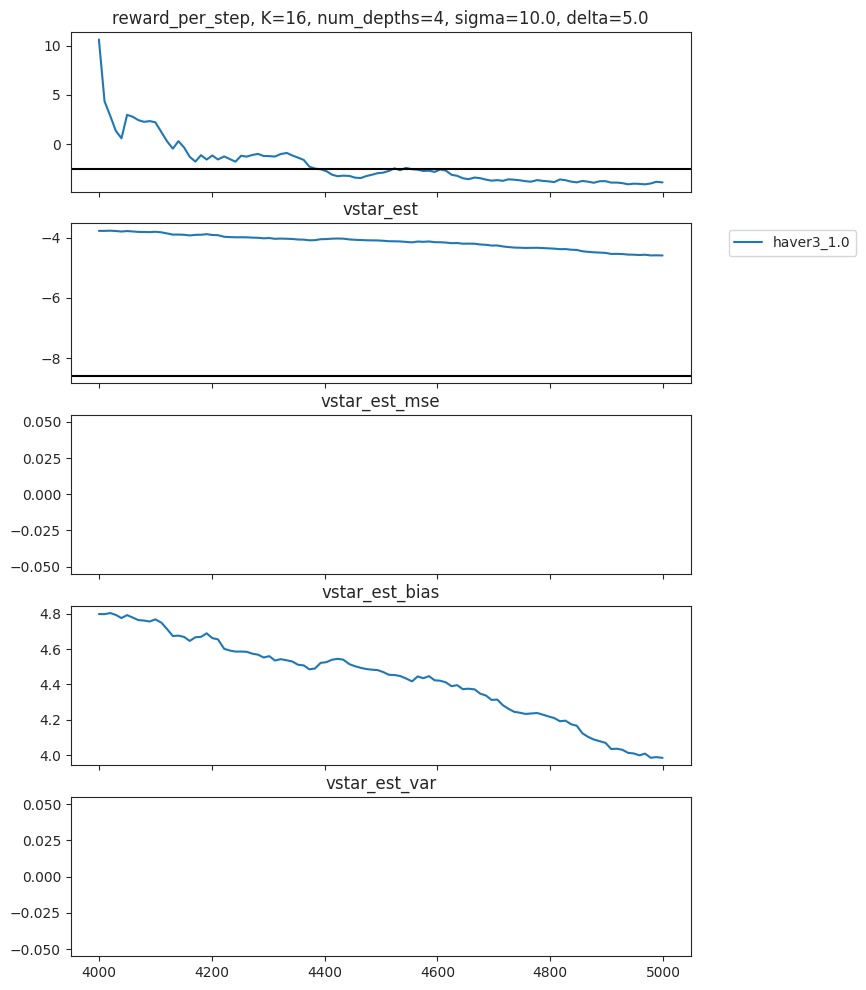

In [3]:

fig, axes = fig, axes = plt.subplots(
        nrows=5, ncols=1, sharex=True, sharey=False, figsize=(8,12))
# axes = [axes]

x_ary = np.linspace(4000, num_steps_train-1, num=100, dtype=np.int32)
# est_name_ary = ["weightedms"]
est_name_ary_unwanted = []
est_name_ary_wanted = [est_name for est_name in est_name_ary[:8] \
                 if est_name not in est_name_ary_unwanted]
for est_name in est_name_ary_wanted:
    # axes[0].plot(x_ary, episode_rewards_dict[est_name][x_ary], label=est_name)
    y_ary = running_avg(episode_rewards_dict[est_name][x_ary], 100)
    axes[0].plot(
        x_ary, y_ary, label=est_name)
    axes[1].plot(x_ary, episode_vstar_est_dict[est_name][x_ary], label=est_name)
    axes[2].plot(x_ary, episode_vstar_est_mse_dict[est_name][x_ary], label=est_name)
    axes[3].plot(x_ary, episode_vstar_est_bias_dict[est_name][x_ary], label=est_name)
    axes[4].plot(x_ary, episode_vstar_est_var_dict[est_name][x_ary], label=est_name)

axes[0].axhline(y=optimal_reward_per_step, color="black")
axes[1].axhline(y=optimal_vstar, color="black")
axes[0].set_title(f"reward_per_step, K={num_actions}, num_depths={num_depths}, sigma={action_sigma},"
                    f" delta={gap_deltas[0]}")
axes[1].set_title("vstar_est")
axes[2].set_title("vstar_est_mse")
axes[3].set_title("vstar_est_bias")
axes[4].set_title("vstar_est_var")
# axes[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axes[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# axes[2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

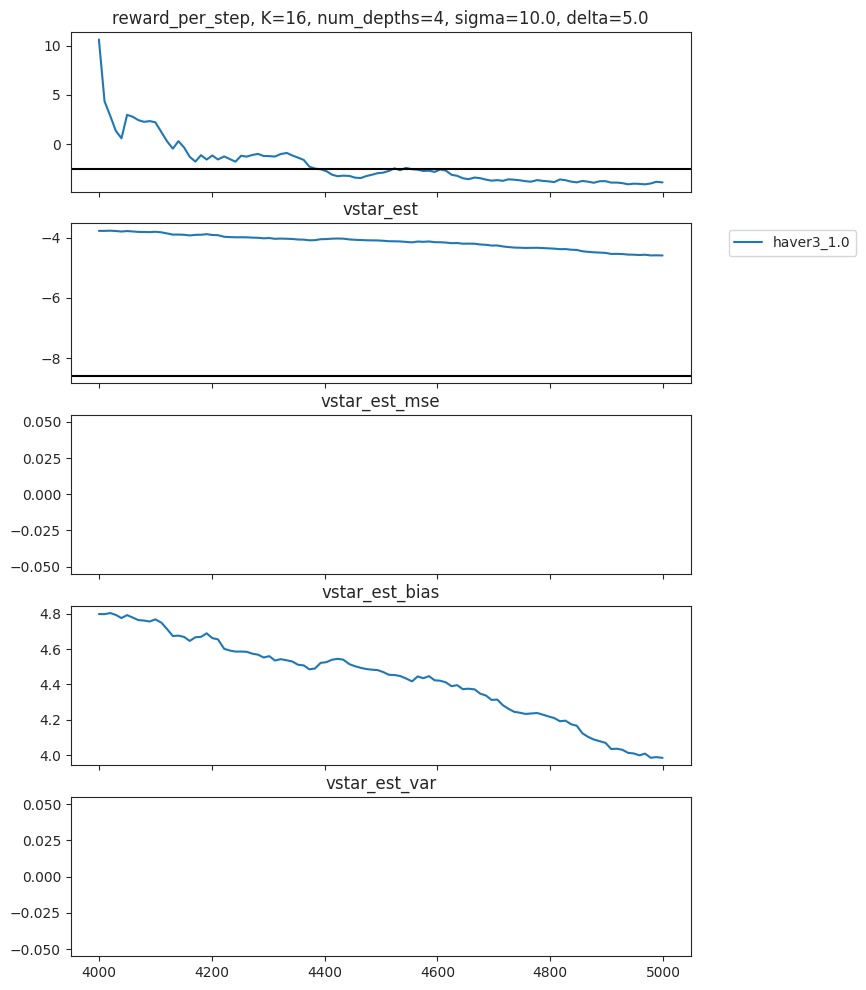

In [4]:

fig, axes = fig, axes = plt.subplots(
        nrows=5, ncols=1, sharex=True, sharey=False, figsize=(8,12))
# axes = [axes]

x_ary = np.linspace(4000, num_steps_train-1, num=100, dtype=np.int32)
# est_name_ary = ["weightedms"]
est_name_ary_unwanted = ["weightedms", "weightedms2"]
est_name_ary_wanted = [est_name for est_name in est_name_ary[:8] \
                 if est_name not in est_name_ary_unwanted]
for est_name in est_name_ary_wanted:
    # axes[0].plot(x_ary, episode_rewards_dict[est_name][x_ary], label=est_name)
    y_ary = running_avg(episode_rewards_dict[est_name][x_ary], 100)
    axes[0].plot(
        x_ary, y_ary, label=est_name)
    axes[1].plot(x_ary, episode_vstar_est_dict[est_name][x_ary], label=est_name)
    axes[2].plot(x_ary, episode_vstar_est_mse_dict[est_name][x_ary], label=est_name)
    axes[3].plot(x_ary, episode_vstar_est_bias_dict[est_name][x_ary], label=est_name)
    axes[4].plot(x_ary, episode_vstar_est_var_dict[est_name][x_ary], label=est_name)

axes[0].axhline(y=optimal_reward_per_step, color="black")
axes[1].axhline(y=optimal_vstar, color="black")
axes[0].set_title(f"reward_per_step, K={num_actions}, num_depths={num_depths}, sigma={action_sigma},"
                    f" delta={gap_deltas[0]}")
axes[1].set_title("vstar_est")
axes[2].set_title("vstar_est_mse")
axes[3].set_title("vstar_est_bias")
axes[4].set_title("vstar_est_var")
# axes[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axes[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# axes[2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [5]:

for est_name in est_name_ary:
    print(f"\n-> est_name = {est_name}")
    Q_table = Q_table_dict[est_name]
    Q_nvisits = Q_nvisits_dict[est_name]
    for i_row in range(num_depths):
        for j_col in range(num_actions):
            print(f"{i_row} {j_col}: {Q_table[i_row,j_col]}, \n     {Q_nvisits[i_row,j_col]}")

 


-> est_name = haver3_1.0
0 0: [ -4.4   -4.39  -5.19  -4.44  -4.43  -4.76  -4.87  -4.56 -15.94  -9.12
 -11.98 -12.12 -13.01  -8.42 -14.54 -18.42], 
     [ 38. 469.   6. 193. 313.  56.  32. 105.   5.   5.   4.   4.   2.  10.
   4.   4.]
0 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 2: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 3: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 4: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 5: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 6: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 7: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 
     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.